In [2]:
!pip install sklearn
!pip install  keras
!pip install  nltk
!pip install  pandas
!pip install  numpy
!pip install  re
!pip install  codecs

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re
ERROR: Could not find a version that satisfies the requirement codecs (from versions: none)
ERROR: No matching distribution found for codecs


In [3]:
import sklearn
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yasserh/twitter-tweets-sentiment-dataset")

100%|██████████| 1.23M/1.23M [00:00<00:00, 33.9MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/yasserh/twitter-tweets-sentiment-dataset/versions/1


### Проверка данных

Это выглядит нормально, но на самом деле нам не нужны URL-адреса, и мы хотели бы, чтобы все наши слова были строчными (Hello и HELLO очень похожи для нашей задачи).

In [6]:
questions = pd.read_csv(path + '/Tweets.csv', encoding='utf-8')
questions.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative

In [27]:
questions.isnull().values.any()

False

In [26]:
questions = questions.dropna()

In [7]:
questions.tail()

textID                                               text  \
27476  4eac33d1c0   wish we could come see u on Denver  husband l...   
27477  4f4c4fc327   I`ve wondered about rake to.  The client has ...   
27478  f67aae2310   Yay good for both of you. Enjoy the break - y...   
27479  ed167662a5                         But it was worth it  ****.   
27480  6f7127d9d7     All this flirting going on - The ATG smiles...   

                                           selected_text sentiment  
27476                                             d lost  negative  
27477                                      , don`t force  negative  
27478                          Yay good for both of you.  positive  
27479                         But it was worth it  ****.  positive  
27480  All this flirting going on - The ATG smiles. Y...   neutral

In [8]:
questions.describe()

textID                                  text selected_text  \
count        27481                                 27480         27480   
unique       27481                                 27480         22463   
top     cb774db0d1   I`d have responded, if I were going          good   
freq             1                                     1           199   

       sentiment  
count      27481  
unique         3  
top      neutral  
freq       11118

Давайте воспользуемся регулярными выражениями, чтобы очистить данные и сохранить их на диск для будущего использования.

In [28]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

questions = standardize_text(questions, "text")

questions.to_csv("clean_data.csv")
questions.head()

textID                                               text  \
0  cb774db0d1                i`d have responded, if i were going   
1  549e992a42      sooo sad i will miss you here in san diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative

In [29]:
clean_questions = pd.read_csv("clean_data.csv")
clean_questions.tail()

Unnamed: 0      textID  \
27475       27476  4eac33d1c0   
27476       27477  4f4c4fc327   
27477       27478  f67aae2310   
27478       27479  ed167662a5   
27479       27480  6f7127d9d7   

                                                    text  \
27475   wish we could come see u on denver  husband l...   
27476   i`ve wondered about rake to.  the client has ...   
27477   yay good for both of you. enjoy the break - y...   
27478                         but it was worth it  ****.   
27479     all this flirting going on - the atg smiles...   

                                           selected_text sentiment  
27475                                             d lost  negative  
27476                                      , don`t force  negative  
27477                          Yay good for both of you.  positive  
27478                         But it was worth it  ****.  positive  
27479  All this flirting going on - The ATG smiles. Y...   neutral

### Анализ данных

Посмотрим на баланс данных

In [30]:
clean_questions.groupby("sentiment").count()

Unnamed: 0  textID   text  selected_text
sentiment                                          
negative         7781    7781   7781           7781
neutral         11117   11117  11117          11117
positive         8582    8582   8582           8582

In [31]:
clean_questions["text"]

0                      i`d have responded, if i were going
1            sooo sad i will miss you here in san diego!!!
2                                my boss is bullying me...
3                           what interview! leave me alone
4         sons of ****, why couldn`t they put them on t...
                               ...                        
27475     wish we could come see u on denver  husband l...
27476     i`ve wondered about rake to.  the client has ...
27477     yay good for both of you. enjoy the break - y...
27478                           but it was worth it  ****.
27479       all this flirting going on - the atg smiles...
Name: text, Length: 27480, dtype: object

Данные выглядят вполне сбалансированными

Нарисуем карту слов.

Unnamed: 0                                                     315
textID                                                  ddd4dd7be4
text             it looks like the office tv does get mlb netwo...
selected_text    It looks like the office TV DOES get MLB Netwo...
sentiment                                                  neutral
Name: 314, dtype: object
 i`d have responded, if i were going  sooo sad i will miss you here in san diego!!! my boss is bullying me...  what interview! leave me alone  sons of ****, why couldn`t they put them on the releases we already bought ://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth 2am feedings for the baby are fun when he is all smiles and coos soooo high  both of you  journey!? wow... u just became cooler.  hehe... (is that possible!?)  as much as i love to be hopeful, i reckon the chances are minimal =p i`m never gonna get my cake and stuff i really really like the song love story by taylor swift my sharpi

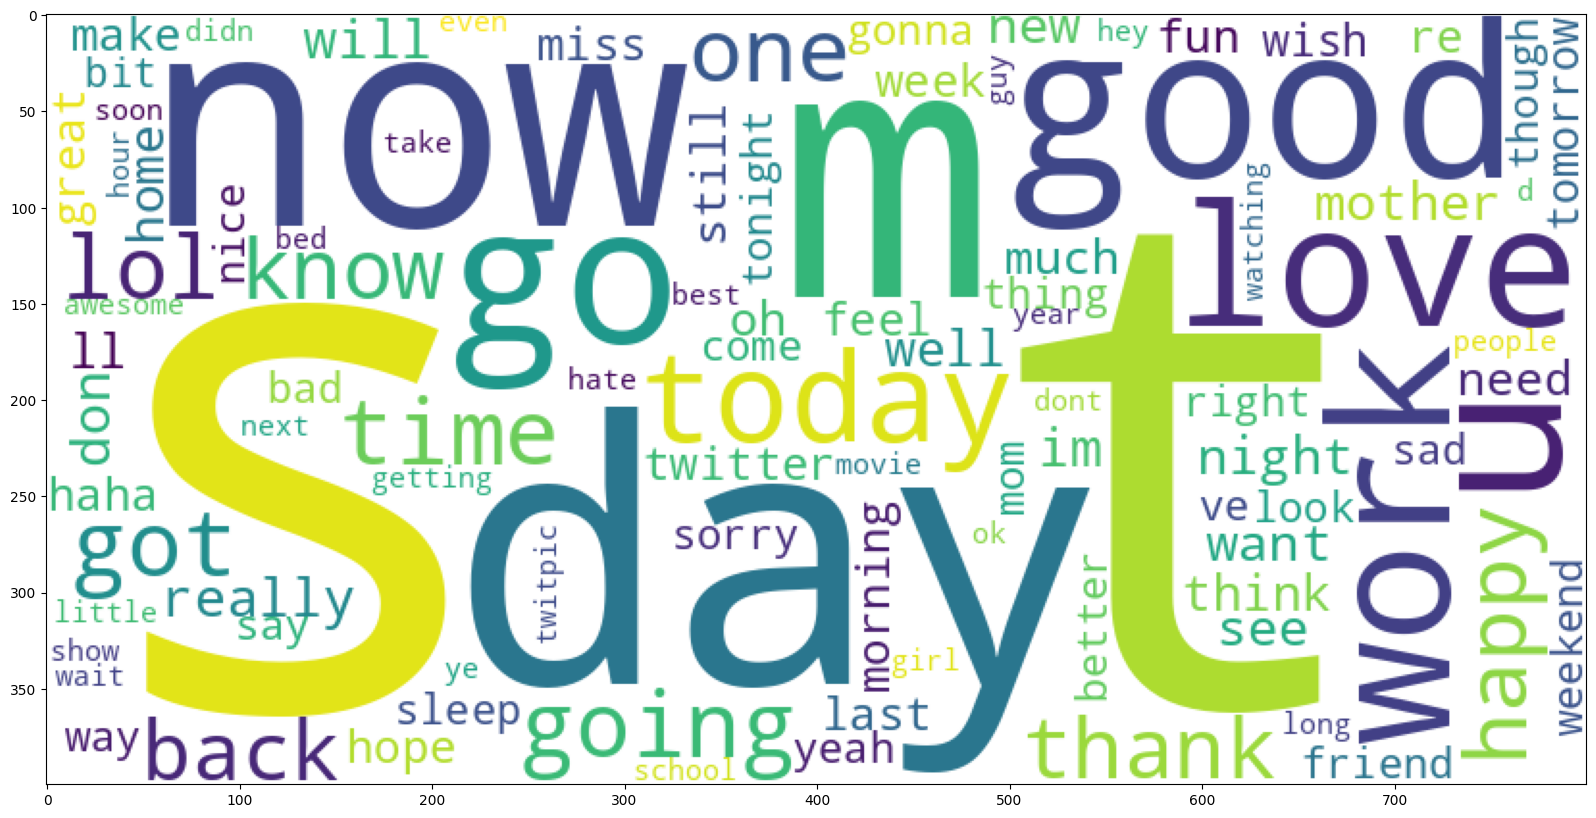

In [32]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

print(clean_questions.iloc[314])

a = " ".join(clean_questions["text"])
print(a)

en_cloud = WordCloud(max_words=100, background_color='white',
                     width=800, height=400,
                     collocations=False).generate(a)
fig = plt.figure(figsize=(20, 10))
plt.imshow(en_cloud);

### Наши данные чисты, теперь их нужно подготовить

Теперь, когда наши входные данные стали более разумными, давайте преобразуем их так, чтобы наша модель могла их понять. Из этого следует:
- Токенизация предложений в список отдельных слов
- Создание тестового сплита трейна
- Еще немного проверяем наши данные, чтобы подтвердить результаты.

In [33]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)
clean_questions.head()

Unnamed: 0      textID                                               text  \
0           0  cb774db0d1                i`d have responded, if i were going   
1           1  549e992a42      sooo sad i will miss you here in san diego!!!   
2           2  088c60f138                          my boss is bullying me...   
3           3  9642c003ef                     what interview! leave me alone   
4           4  358bd9e861   sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  \
0  I`d have responded, if I were going   neutral   
1                             Sooo SAD  negative   
2                          bullying me  negative   
3                       leave me alone  negative   
4                        Sons of ****,  negative   

                                              tokens  
0        [i, d, have, responded, if, i, were, going]  
1  [sooo, sad, i, will, miss, you, here, in, san,...  
2                       [my, boss, is, bullying, me]  
3                [what, interview, leave, me, alone]  
4  [sons, of, why, couldn, t, they, put, them, on...

### Анализируем датасет дальше

In [34]:
from tensorflow.keras.preprocessing.text import Tokenizer
from  keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

367556 words total, with a vocabulary size of 26477
Max sentence length is 39


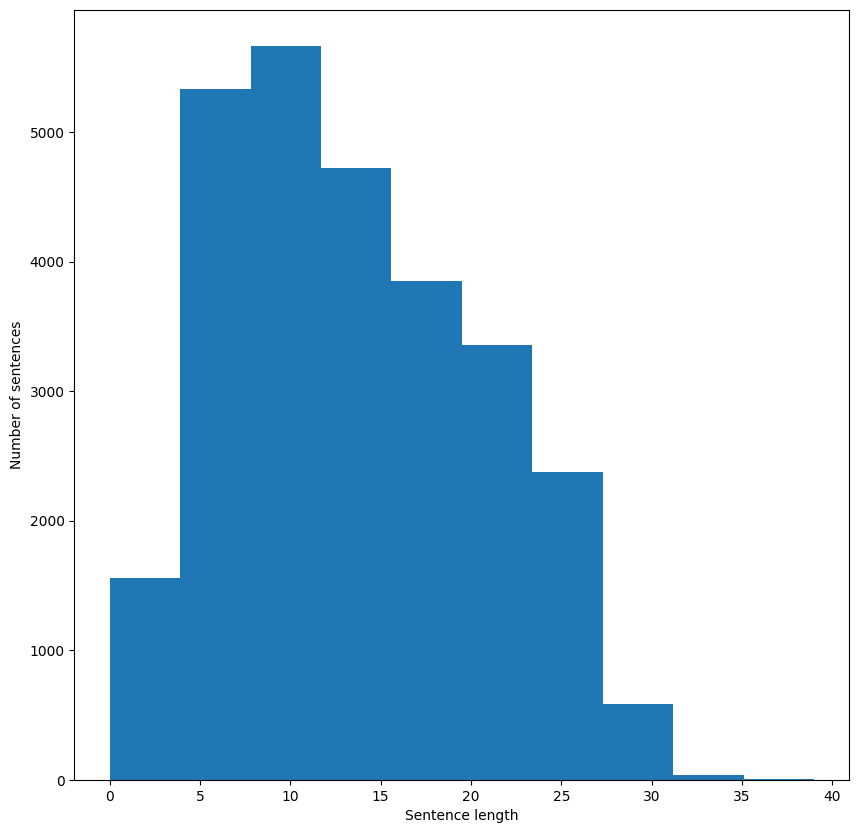

In [35]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

## К машинному обучению
Теперь, когда наши данные очищены и подготовлены, давайте займемся машинным обучением.

## Enter embeddings
**Мешок слов** - мы можем построить словарь всех уникальных слов в нашем датасете, и ассоциировать уникальный индекс каждому слову в словаре. Каждое предложение тогда можно будет отобразить списком, длина которого равна числу уникальных слов в нашем словаре, а в каждом индексе в этом списке будет хранится, сколько раз данное слово встречается в предложении.

## Bag of Words Counts

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer


list_corpus = clean_questions["text"].tolist()
list_labels = clean_questions["sentiment"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2,
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

### Визуализируем векторные представления

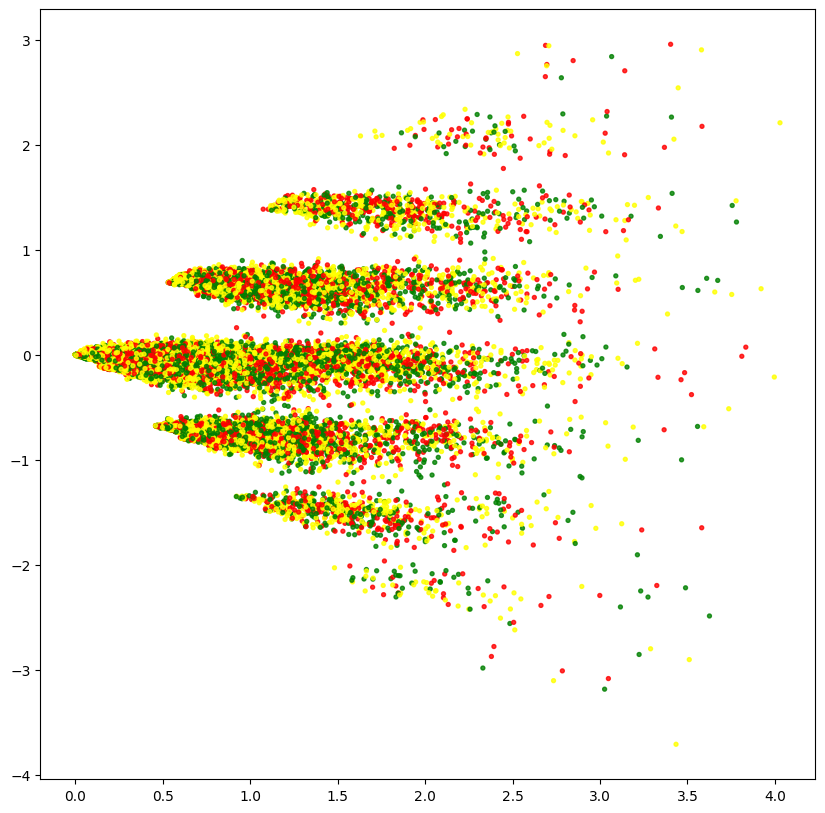

In [45]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['green','yellow','red']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))

fig = plt.figure(figsize=(10, 10))
hash = {'positive':0, 'neutral':1, 'negative':2}
test_labels = [hash[target] for target in y_train]
plot_LSA(X_train_counts, test_labels)
plt.show()

### Fitting a classifier

In [46]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


### Метрики!


In [69]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, r2_score, classification_report

def get_metrics(y_test, y_predicted):
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')

    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')

    r2 = r2_score(y_test, y_predicted)
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1, r2

y_test_labels = [hash[target] for target in y_test]
y_predicted_labels = [hash[target] for target in y_predicted_counts]
accuracy, precision, recall, f1, r2 = get_metrics(y_test_labels, y_predicted_labels)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, r2 = %.3f" % (accuracy, precision, recall, f1,r2))

accuracy = 0.648, precision = 0.648, recall = 0.648, f1 = 0.648, r2 = 0.191


### Инспектирование
Матрица ошибок

In [47]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

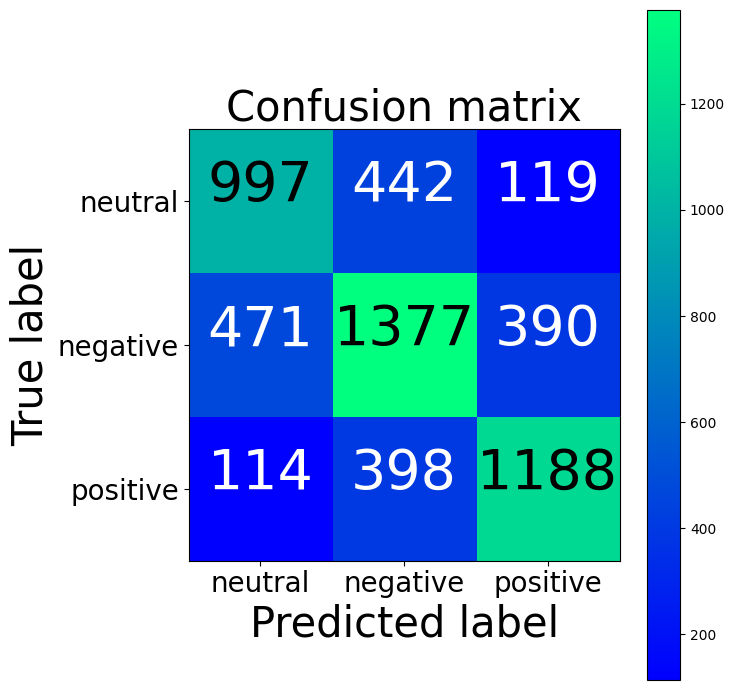

In [56]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(7, 7))
plot = plot_confusion_matrix(cm, classes=['neutral','negative','positive'], normalize=False, title='Confusion matrix')
plt.show()

### Инспектируем дальше

Посмотрим, на каких признаках наш классификатор делает предсказание.

In [57]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}

    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

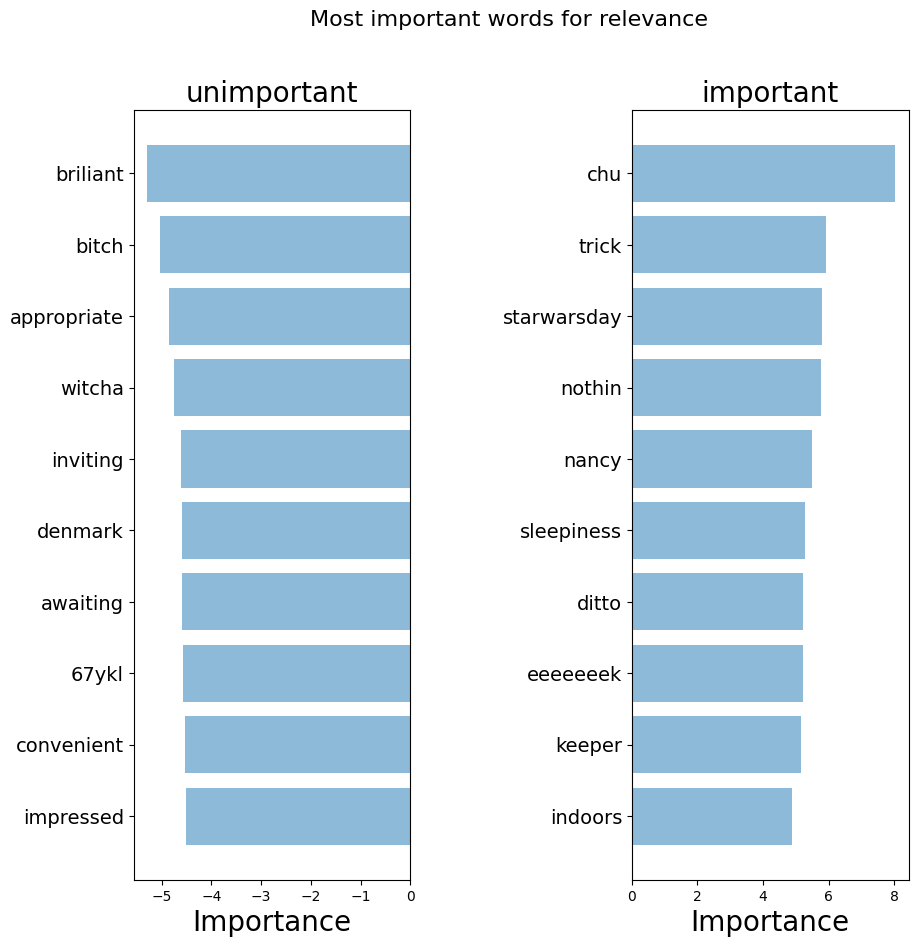

In [79]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])

    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)

    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]

    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]

    fig = plt.figure(figsize=(10, 10))

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('relevant', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

# Шаг 6. Учтите структуру словаря

### TFIDF Bag of Words

Чтобы помочь нашей модели сфокусироваться на значимых словах, мы можем использовать скоринг TF-IDF (Term Frequency, Inverse Document Frequency) поверх нашей модели «мешка слов». TF-IDF взвешивает на основании того, насколько они редки в нашем датасете, понижая в приоритете слова, которые встречаются слишком часто и просто добавляют шум. Ниже приводится проекция метода главных компонент, позволяющая оценить наше новое представление.

In [60]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    train = tfidf_vectorizer.fit_transform(data)
    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

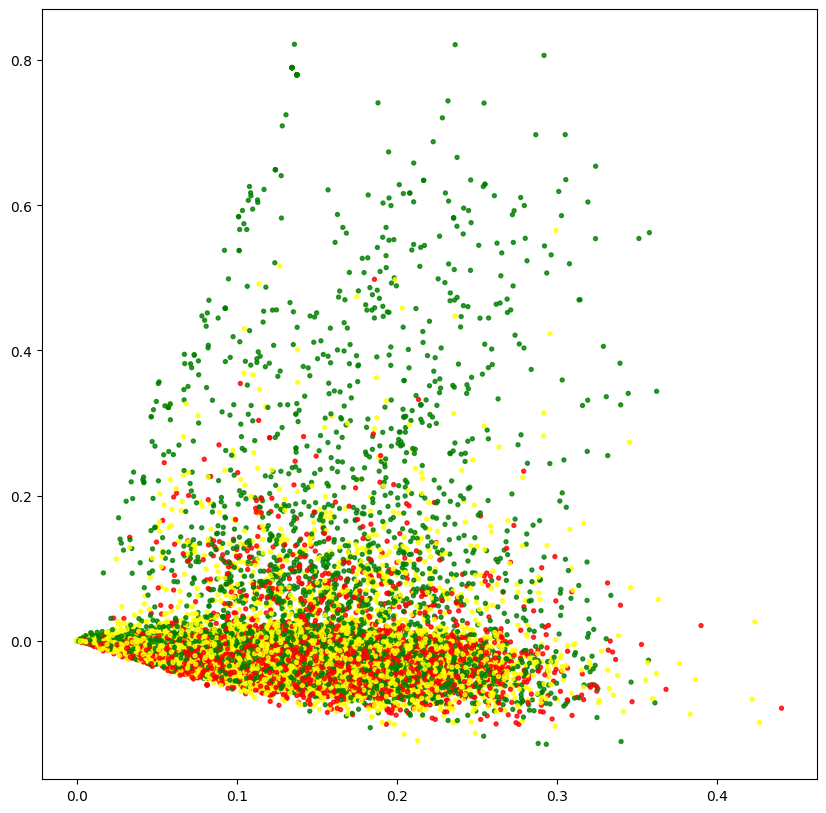

In [63]:
fig = plt.figure(figsize=(10, 10))
plot_LSA(X_train_tfidf, test_labels)
plt.show()

In [64]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [71]:
y_test_labels = [hash[target] for target in y_test]
y_predicted_labels = [hash[target] for target in y_predicted_tfidf]

accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf, r2_tfidf = get_metrics(y_test_labels, y_predicted_labels)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, r2 = %.3f"  % (accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf, r2_tfidf))


accuracy = 0.658, precision = 0.658, recall = 0.658, f1 = 0.658, r2 = 0.227


Результаты получше

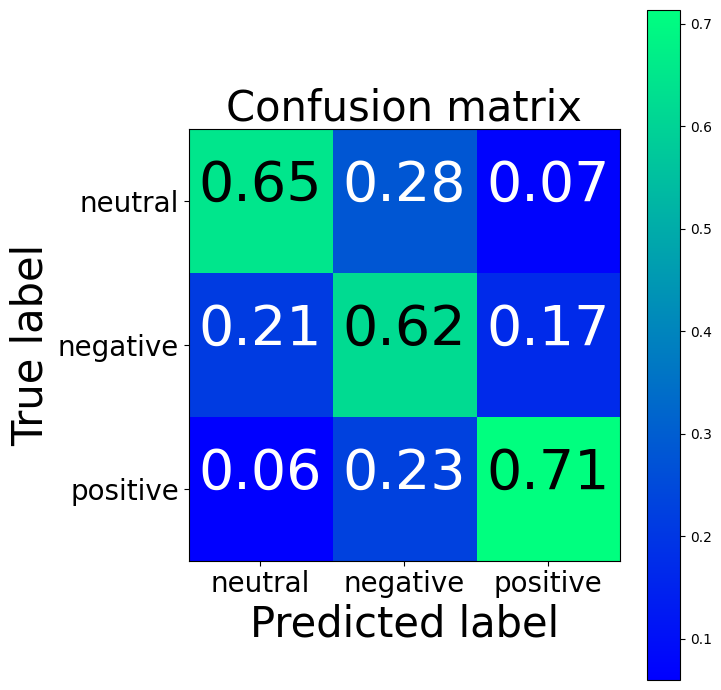

TFIDF confusion matrix
[[1012  437  109]
 [ 473 1390  375]
 [ 102  385 1213]]
BoW confusion matrix
[[ 997  442  119]
 [ 471 1377  390]
 [ 114  398 1188]]


In [76]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(7, 7))
plot = plot_confusion_matrix(cm2, classes=['neutral','negative','positive'], normalize=True, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

### Посмотрим, какие признаки были важны для предсказания


In [77]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

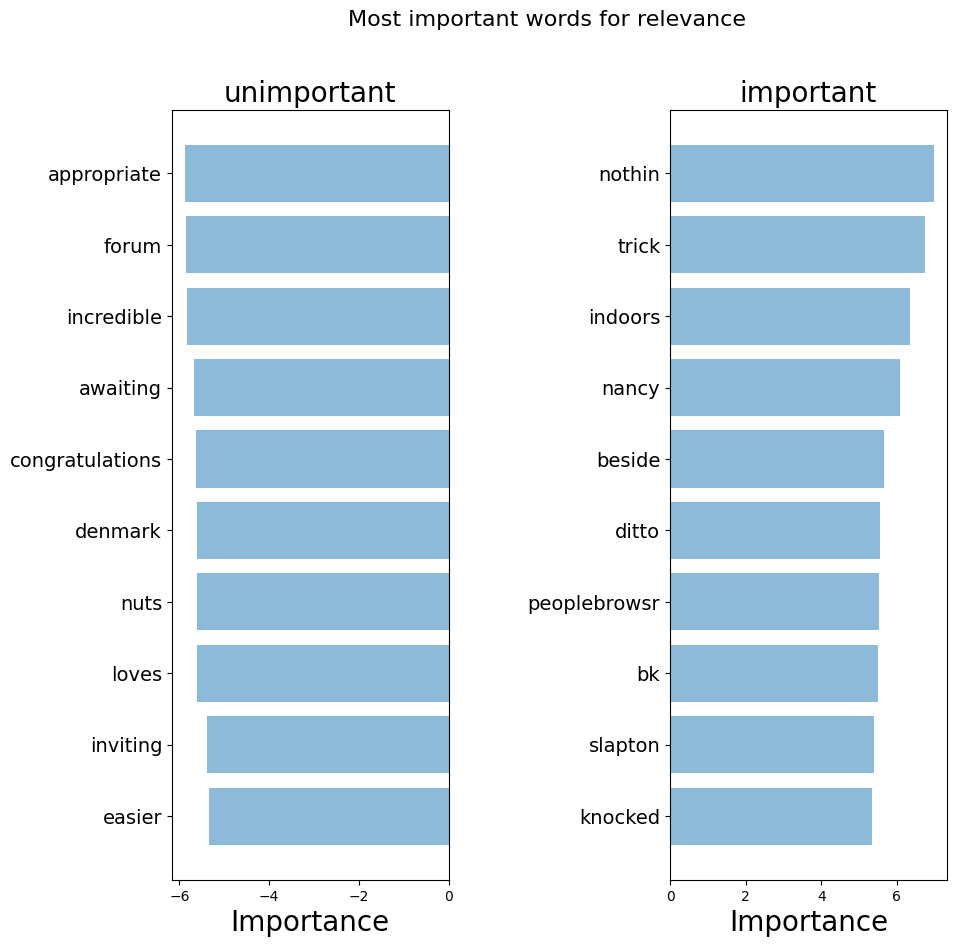

In [80]:
top_scores = [a[0] for a in importance_tfidf[1]['tops']]
top_words = [a[1] for a in importance_tfidf[1]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[1]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

### Применение семантики

Нам потребуется захватить семантическое (смысловое) значение слов — это означает, что для нас важно понимать, что слова «хороший» и «позитивный» ближе друг к другу, чем слова «абрикос» и «континент». Мы воспользуемся инструментом Word2Vec, который поможет нам сопоставить значения слов.

In [81]:
!python -m gensim.downloader --download word2vec-google-news-300

2024-12-01 13:19:42,359 : __main__ : INFO : Creating /root/gensim-data
[==================================================] 100.0% 1662.8/1662.8MB downloaded
2024-12-01 13:21:13,385 : __main__ : INFO : word2vec-google-news-300 downloaded
2024-12-01 13:21:13,386 : __main__ : INFO : Data has been installed and data path is /root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [82]:
import gensim

# Load Google's pre-trained Word2Vec model.
word2vec_path = "~/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [83]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors,
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [84]:
embeddings = get_word2vec_embeddings(word2vec, clean_questions)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels,
                                                                                        test_size=0.2, random_state=40)

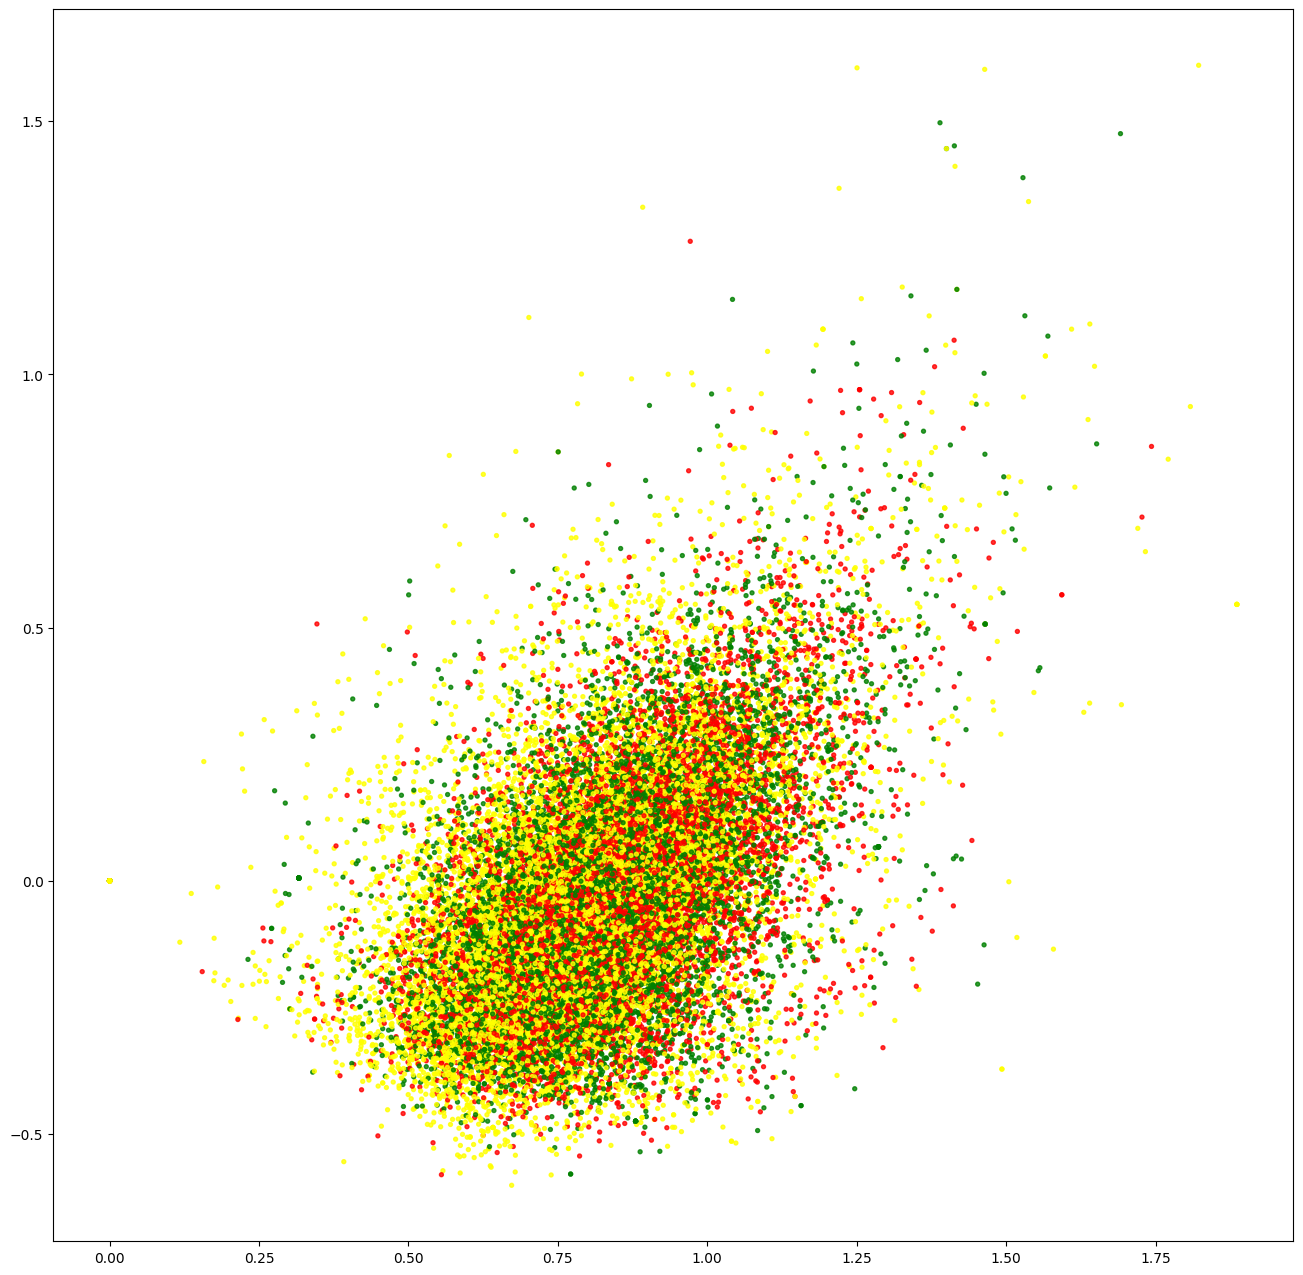

In [88]:
fig = plt.figure(figsize=(16, 16))
l_labels = [hash[target] for target in list_labels]
plot_LSA(embeddings, l_labels)
plt.show()

In [89]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [91]:
y_test_labels = [hash[target] for target in y_test_word2vec]
y_predicted_labels = [hash[target] for target in y_predicted_word2vec]

accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec, r2_word2vec = get_metrics(y_test_labels, y_predicted_labels)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, r2 = %.3f" % (accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec, r2_word2vec))

accuracy = 0.666, precision = 0.666, recall = 0.666, f1 = 0.666, r2 = 0.222


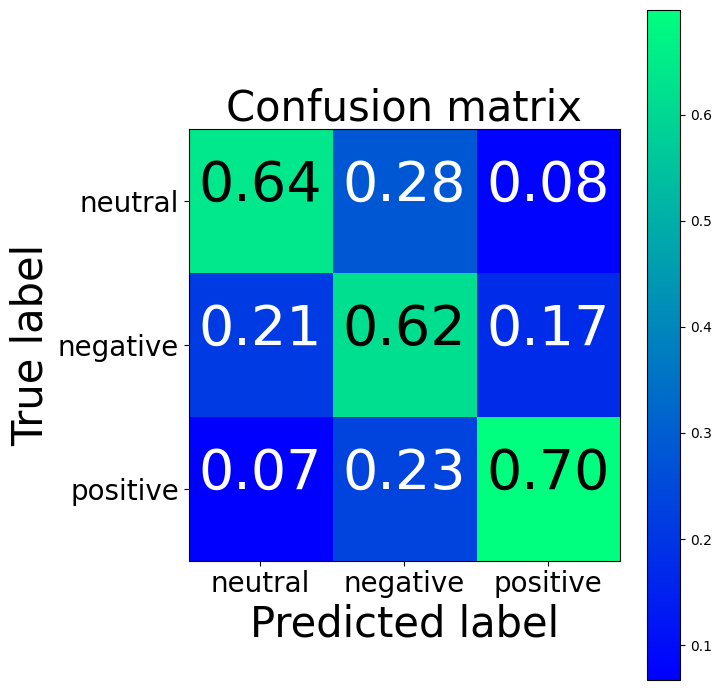

Word2Vec confusion matrix
[[1045  397  116]
 [ 476 1406  356]
 [ 116  376 1208]]
TFIDF confusion matrix
[[1012  437  109]
 [ 473 1390  375]
 [ 102  385 1213]]
BoW confusion matrix
[[ 997  442  119]
 [ 471 1377  390]
 [ 114  398 1188]]


In [94]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(7, 7))
plot = plot_confusion_matrix(cm, classes=['neutral','negative','positive'], normalize=True, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

Все лучше и лучше!

### Further inspection
Поскольку наши векторные представления более не представлены в виде вектора с одним измерением на слово, как было в предыдущих моделях, теперь тяжелее понять, какие слова наиболее релевантны для нашей классификации. Несмотря на то, что мы по-прежнему обладаем доступом к коэффициентам нашей логистической регрессии, они относятся к 300 измерениям наших вложений, а не к индексам слов.

Для столь небольшого прироста точности, полная потеря возможности объяснить работу модели — это слишком жесткий компромисс. К счастью, при работе с более сложными моделями мы можем использовать интерпретаторы наподобие LIME, которые применяются для того, чтобы получить некоторое представление о том, как работает классификатор.

#### LIME

LIME доступен на Github в виде открытого пакета. Данный интерпретатор, работающий по принципу черного ящика, позволяет пользователям объяснять решения любого классификатора на одном конкретном примере при помощи изменения ввода (в нашем случае — удаления слова из предложения) и наблюдения за тем, как изменяется предсказание.

Давайте взглянем на пару объяснений для предложений из нашего датасета.

In [95]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4374ec0fdc8f644e6e1852e16a0a112234863e717f6cf3a1b358b4f464fbe963
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [96]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(list_corpus, list_labels, test_size=0.2,
                                                                                random_state=40)
vector_store = word2vec
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(count_vectorizer, clf)

In [100]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ["irrelevant", "relevant", "unknown"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [101]:
y_test_labels = [hash[target] for target in y_test_data]
visualize_one_exp(X_test_data, y_test_labels, 65)

Index: 65
True class: relevant


In [102]:
visualize_one_exp(X_test_data, y_test_labels, 60)

Index: 60
True class: relevant


Впрочем, у нас нет достаточного количества времени, чтобы исследовать тысячи примеров из нашего датасета. Вместо этого, давайте запустим LIME на репрезентативной выборке тестовых данных, и посмотрим, какие слова встречаются регулярно и вносят наибольший вклад в конечный результат. Используя данный подход, мы можем получить оценки значимости слов аналогично тому, как мы делали это для предыдущих моделей, и валидировать предсказания нашей модели.

In [103]:
import random
from collections import defaultdict

random.seed(40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()

    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)

    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)

        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]

    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'Irrelevant',
    1: 'Relevant',
    2: 'Unsure'
}
sorted_contributions = get_statistical_explanation(X_test_data, 100, word2vec_pipeline, label_to_text)

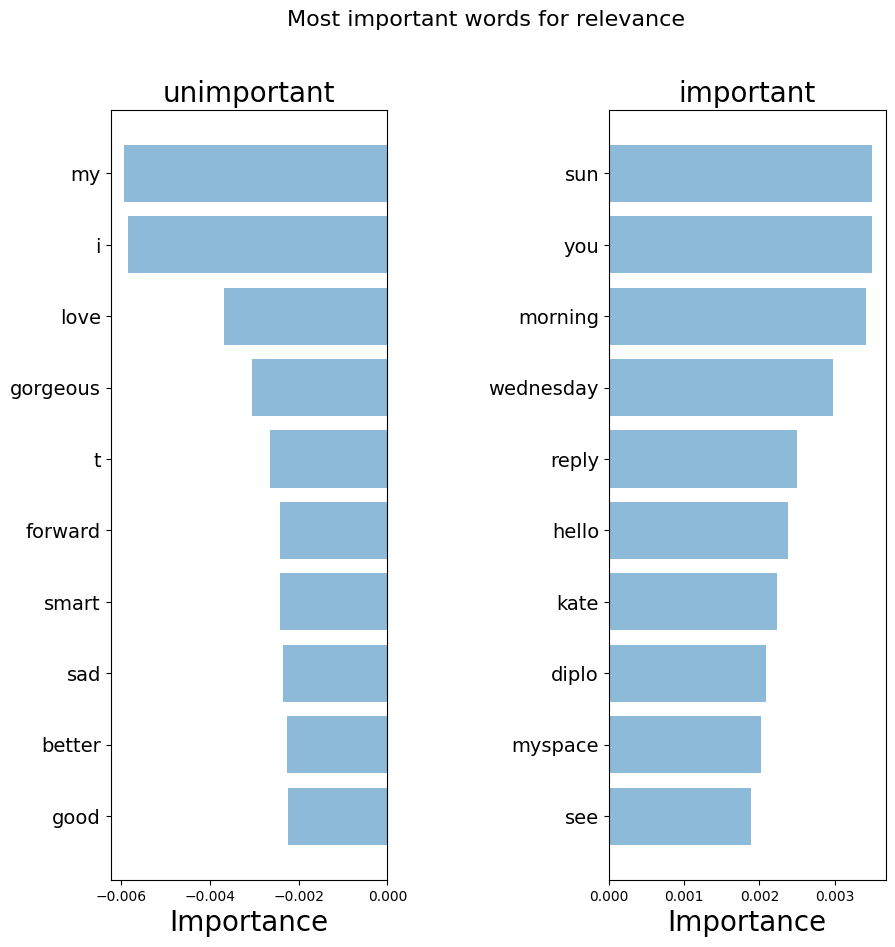

In [104]:
# First index is the class (Disaster)
# Second index is 0 for detractors, 1 for supporters
# Third is how many words we sample
top_words = sorted_contributions['Relevant']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['Relevant']['supporters'][:10].tolist()
bottom_words = sorted_contributions['Relevant']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['Relevant']['detractors'][:10].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

# Шаг 8. Использование синтаксиса при применении end-to-end подходов

Мы рассмотрели быстрые и эффективные подходы для генерации компактных векторных представлений предложений. Однако, опуская порядок слов, мы отбрасываем всю синтаксическую информацию из наших предложений. Если эти методы не дают достаточных результатов, вы можете использовать более сложную модель, которая принимает целые выражения в качестве ввода и предсказывает метки, без необходимости построения промежуточного представления. Распространенный для этого способ состоит в рассмотрении предложения как последовательности индивидуальных векторов слов с использованием или Word2Vec, или более свежих подходов вроде GloVe или CoVe. Именно этим мы и займемся далее.

### CNN для NLP

Сверточные нейронные сети для классификации предложений (CNNs for Sentence Classification) обучаются очень быстро и могут сослужить отличную службу в качестве входного уровня в архитектуре глубокого обучения. Несмотря на то, что сверточные нейронные сети (CNN) в основном известны своей высокой производительностью на данных-изображениях, они показывают превосходные результаты при работе с текстовыми данными, и обычно гораздо быстрее обучаются, чем большинство сложных подходов NLP (например, LSTM-сети и архитектуры Encoder/Decoder ). Эта модель сохраняет порядок слов и обучается ценной информации о том, какие последовательности слов служат предсказанием наших целевых классов. В отличии от предыдущих моделей, она в курсе существования разницы между фразами «Лёша ест растения» и «Растения едят Лёшу».

First, let's embed our text!

In [107]:
from tensorflow.keras.preprocessing.text  import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE = len(VOCAB)

VALIDATION_SPLIT=.2
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(clean_questions["text"].tolist())
sequences = tokenizer.texts_to_sequences(clean_questions["text"].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
y_labels = [hash[target] for target in clean_questions["sentiment"]]
labels = to_categorical(np.asarray(y_labels))

indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

Found 26597 unique tokens.
(26598, 300)


Собираем простейшую CNN

In [109]:
from keras.layers import Dense, Input, Flatten, Dropout, Concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    embedding_layer = Embedding(
        num_words,
        embedding_dim,
        weights=[embeddings],
        input_length=max_sequence_length,
        trainable=trainable)
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    convs = []
    filter_sizes = [3,4,5]
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)
    l_merge = Concatenate(axis=1)(convs)
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)
    if extra_conv==True:
        x = Dropout(0.5)(l_merge)
    else:
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    preds = Dense(labels_index, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['acc'])
    return model

Now let's train our Neural Network

In [111]:
x_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM,
                len(list(clean_questions["sentiment"].unique())), False)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [113]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=256)

Epoch 1/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 480ms/step - acc: 0.7197 - loss: 0.6533 - val_acc: 0.7102 - val_loss: 0.6821
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 34s 396ms/step - acc: 0.7511 - loss: 0.5953 - val_acc: 0.7074 - val_loss: 0.6846
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 42s 403ms/step - acc: 0.7726 - loss: 0.5505 - val_acc: 0.7149 - val_loss: 0.6732


In [114]:
y_pred = model.predict(x_val)

172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step


In [115]:
y_pred_cnn = np.argmax(y_pred, axis=1)
y_val_cnn = np.argmax(y_val, axis=1)

In [116]:
y_val_cnn

array([1, 2, 2, ..., 1, 0, 1])

In [117]:
accuracy_cnn, precision_cnn, recall_cnn, f1_cnn, r2_cnn = get_metrics(y_val_cnn, y_pred_cnn)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, r2 = %.3f" % (accuracy_cnn, precision_cnn, recall_cnn, f1_cnn, r2_cnn))

accuracy = 0.715, precision = 0.716, recall = 0.715, f1 = 0.715, r2 = 0.366


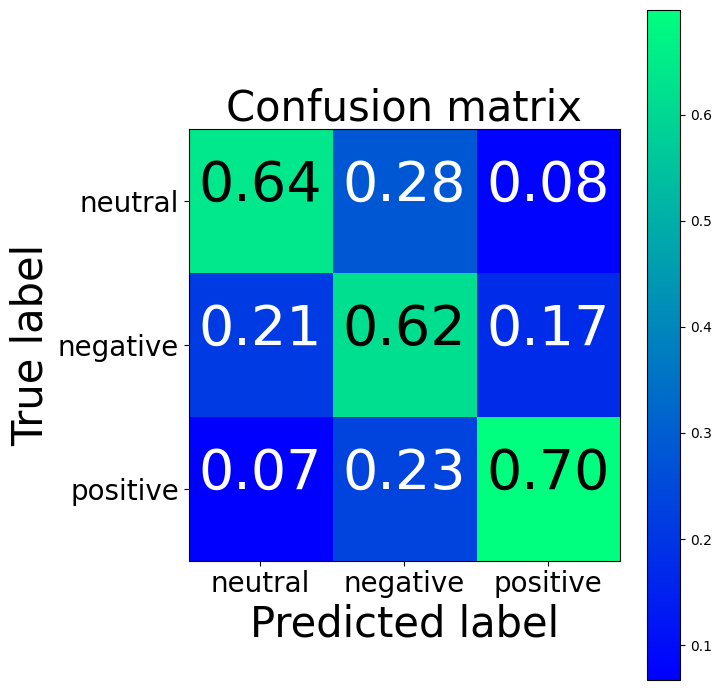

CNN confusion matrix
[[1266  344   98]
 [ 293 1510  424]
 [  70  338 1153]]
Word2Vec confusion matrix
[[1045  397  116]
 [ 476 1406  356]
 [ 116  376 1208]]
TFIDF confusion matrix
[[1012  437  109]
 [ 473 1390  375]
 [ 102  385 1213]]
BoW confusion matrix
[[ 997  442  119]
 [ 471 1377  390]
 [ 114  398 1188]]


In [120]:
cm_cnn = confusion_matrix(y_val_cnn, y_pred_cnn)
fig = plt.figure(figsize=(7, 7))
plot = plot_confusion_matrix(cm, classes=['neutral','negative','positive'], normalize=True, title='Confusion matrix')
plt.show()

print("CNN confusion matrix")
print(cm_cnn)
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)